In [ ]:
save_model_during_training = False
restore_weights_during_training = False
print_debugging_info = True
generate_validation_slpit = True
evaluate_on_test_set = False
print_training_info = True

## Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


## Import Libraries

In [ ]:
import os
import gc
import warnings
from datetime import datetime
import math

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as tfkb
from tensorflow.keras import callbacks as tfkc
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## Load and inspect the data

In [ ]:
#data_no_aliens = np.load("No_aliens_float64.npz")
#X_train_val = data_no_aliens['arr_0']
#y_train_val = data_no_aliens['arr_1']

# Load the test set
data = np.load("mars_for_students.npz")
X_test = data["test_set"]

# Add color channel
#X_train_val = X_train_val[..., np.newaxis].astype('float32')
#X_test = X_test[..., np.newaxis].astype('float32')

# Load the training and validation sets
data_no_aliens = np.load("DistortedRocks.npz")
X_train = data_no_aliens['arr_0']
y_train = data_no_aliens['arr_1']
X_val = data_no_aliens['arr_2']
y_val = data_no_aliens['arr_3']

# Add color channel
X_train = X_train[..., np.newaxis].astype('float32')
X_val = X_val[..., np.newaxis].astype('float32')
X_test = X_test[..., np.newaxis].astype('float32')

#if generate_validation_slpit:
#  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1)
#else:
#  X_train = X_train_val
#  y_train = y_train_val

# Print the datasets' shapes
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2824, 64, 128, 1)
Training y shape: (2824, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [ ]:
# Define the number of classes
category_map = {0:0, 1:1, 2:2, 3:3, 4:4}
num_classes = len(set(category_map.values()))
print(num_classes)

5


In [ ]:
# Define a debugging function used to plot images throughout the notebook
def plot_images(to_plot, num_img, vmin=-1, vmax=-1, cmap='gray'):
    fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

    if vmin == -1 and vmax == -1:
      vmin = min([np.min(to_plot[i]) for i in range(len(to_plot))])
      vmax = max([np.max(to_plot[i]) for i in range(len(to_plot))])

    # Iterate through the selected number of images
    for i in range(num_img):
        ax = axes[i % num_img]
        ax.imshow(np.squeeze(to_plot[i]), vmin=vmin, vmax=vmax,cmap=cmap)
        ax.axis('off')

    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()

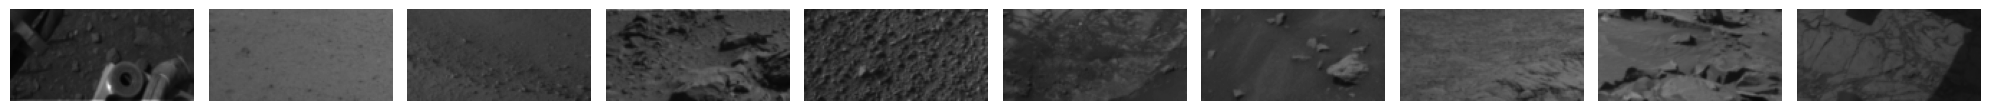

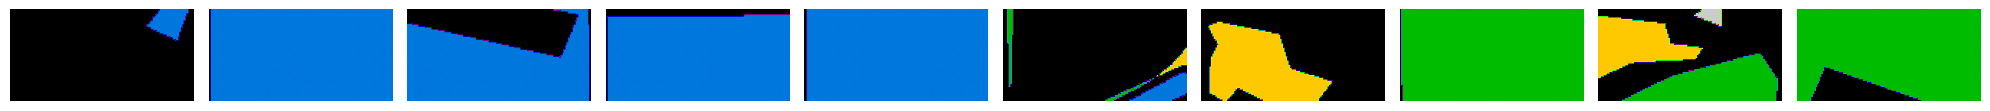

In [ ]:
if print_debugging_info:
  to_plot_x = X_train
  to_plot_y = y_train

  # Display a sample of images from the training-validation dataset
  num_img = 10
  random_indices = random.sample(range(len(to_plot_x)), num_img)
  plot_images(to_plot_x[random_indices], num_img, vmin = 0, vmax = 255, cmap = 'grey')
  plot_images(to_plot_y[random_indices], num_img, vmin = 0, vmax = 4, cmap = 'nipy_spectral')

In [ ]:
label_names = ['background', 'soil', 'bedrock', 'sand', 'bigrock']
#labels = [0.2837526200457317, 0.30416476117886176, 0.2143452267530488, 0.18662192740091463, 0.01111546462144309]

# Find relative pixel frequencies
if 'labels' not in globals():
  labels = [0, 0, 0, 0, 0]
  tot_pixels = 64 * 128 * (len(y_train) + len(y_val))

  for i in range(len(y_train)):
    for j in range(y_train[i].shape[0]):
      for k in range(y_train[i].shape[1]):
        labels[int(y_train[i][j][k])] += 1

  for i in range(len(y_val)):
    for j in range(y_val[i].shape[0]):
      for k in range(y_val[i].shape[1]):
        labels[int(y_val[i][j][k])] += 1

  for i in range(len(labels)):
    labels[i] /= tot_pixels

print("Class frequencies", ", ".join(f"{labels[i]}" for i in range(len(labels))))

Class frequencies 0.2837526200457317, 0.30416476117886176, 0.2143452267530488, 0.18662192740091463, 0.01111546462144309


In [ ]:
# Cleanup useless data to save memory
if 'X_train_val' in globals():
  del X_train_val, y_train_val

del data_no_aliens
del data

gc.collect()

19704

## Augmentation

In [ ]:
brightness = np.empty(0)
contrast = np.empty(0)

min_brightness_pixel = 255
max_brightness_pixel = 0

# Find brightness and contrast statistics for the test set
for i in range(len(X_test)):
  brightness = np.append(brightness, np.mean(X_test[i]))
  contrast = np.append(contrast, np.std(X_test[i]))

  minval = np.min(X_test[i])
  maxval = np.max(X_test[i])
  if minval < min_brightness_pixel:
    min_brightness_pixel = minval
  if maxval > max_brightness_pixel:
    max_brightness_pixel = maxval

min_brightness = np.min(brightness)
max_brightness = np.max(brightness)
mean_brightness = np.mean(brightness)
brightnesses_std = np.std(brightness)

min_contrast = np.min(contrast)
max_contrast = np.max(contrast)
mean_contrast = np.mean(contrast)
contrasts_std = np.std(contrast)

# Print the statistics to console
print(f"Min brightness: {min_brightness}")
print(f"Max brightness: {max_brightness}")
print(f"Mean brightness: {mean_brightness}")
print(f"Brightness std: {brightnesses_std}")
print(f"Min brightness pixel: {min_brightness_pixel}")
print(f"Max brightness pixel: {max_brightness_pixel}")
print(f"Min contrast: {min_contrast}")
print(f"Max contrast: {max_contrast}")
print(f"Mean contrast: {mean_contrast}")
print(f"Contrast std: {contrasts_std}")

Min brightness: 2.6004638671875
Max brightness: 117.8079833984375
Mean brightness: 60.74872153820189
Brightness std: 21.723329587221095
Min brightness pixel: 1.0
Max brightness pixel: 255.0
Min contrast: 0.7545029520988464
Max contrast: 94.91444396972656
Mean contrast: 14.071195284487887
Contrast std: 7.441992713018336


In [ ]:
import scipy.stats as stats
distributions = [stats.norm, stats.expon, stats.uniform, stats.gamma, stats.chi, stats.cauchy, stats.lognorm, stats.triang, stats.trapezoid]

# Find the best distribution to describe brightness and contrast of the samples
def find_best_distribution(data, distributions):
    results = {}
    for dist in distributions:
        params = dist.fit(data)
        ks_stat, p_value = stats.kstest(data, dist.name, args=params)
        results[dist.name] = (ks_stat, p_value, params)
    return sorted(results.items(), key=lambda x: x[1][0])  # Sort by KS Statistic (lower is better)

best_dist_b = find_best_distribution(brightness, distributions)
print(f"Best distribution to describe brightness: {best_dist_b[0][0]} with KS statistic = {best_dist_b[0][1][0]} and parameters {best_dist_b[0][1][2]}")

best_dist_c = find_best_distribution(contrast, distributions)
print(f"Best distribution to describe brightness: {best_dist_c[0][0]} with KS statistic = {best_dist_c[0][1][0]} and parameters {best_dist_c[0][1][2]}")

Best distribution to describe brightness: gamma with KS statistic = 0.024135536594546203 and parameters (12513.30536719237, -2369.8037168003702, 0.19423715311013057)
Best distribution to describe brightness: gamma with KS statistic = 0.020690642720819885 and parameters (3.529895938600397, -0.08975052150556667, 4.0117230531737595)


In [ ]:
@tf.function
def augmentation(image, label, flip_up_down = True):
    # Augmentations that need to be performed on both image and label

    # 1) Distortions
    transformation_matrix = [1, 0, 0, 0, 1, 0, 0, 0]
    transformation_matrix = tf.convert_to_tensor(transformation_matrix, dtype=tf.float32)
    distortion_probability = tf.random.uniform([4])

    # translation: [1, 0, tx, 0, 1, ty, 0, 0]
    if distortion_probability[0] > 0.5:
      trans_std_dev = 0.05
      normal = tf.random.normal(mean=0, stddev=trans_std_dev, shape=[2])
      transformation_matrix = tf.tensor_scatter_nd_update(transformation_matrix, [[2], [5]], [normal[0], normal[1]])

    # scaling: [sx, 0, 0, 0, sy, 0, 0, 0]
    if distortion_probability[1] > 0.5:
      scale_std_dev = 0.1
      normal0 = tf.random.normal(mean=0, stddev=scale_std_dev, shape=[1])
      normal1 = tf.random.normal(mean=0, stddev=scale_std_dev, shape=[1])

      # Don't let the scale factors be too far off each others
      normal1 = tf.clip_by_value(normal1, normal0 - 0.2, normal1 + 0.2)

      # Slight bias towards scaling down (big rocks are often at the edges)
      bias = 0.1
      normal0 = tf.clip_by_value(normal0, -0.25 - bias, 0.25 - bias) + bias
      normal1 = tf.clip_by_value(normal1, -0.25 - bias, 0.25 - bias) + bias
      transformation_matrix = tf.tensor_scatter_nd_update(transformation_matrix, [[0], [4]], [transformation_matrix[0] * (1.0 + normal0[0]), transformation_matrix[4] * (1.0 + normal1[0])])

    # rotating: [math.cos(theta), -math.sin(theta), 0, math.sin(theta), math.cos(theta), 0, 0, 0]
    if distortion_probability[2] > 0.5:
      rot_std_dev = 0.1
      normal = tf.random.normal(mean=0, stddev=rot_std_dev, shape=[1])
      theta = normal[0] * tf.constant(math.pi) / 4
      theta = tf.clip_by_value(theta, -math.pi/2, math.pi/2)
      transformation_matrix = tf.tensor_scatter_nd_update(transformation_matrix, [[0], [1], [3], [4]], [transformation_matrix[0] + tf.math.cos(theta) - 1, transformation_matrix[1] - tf.math.sin(theta), transformation_matrix[3] + tf.math.sin(theta), transformation_matrix[4] + tf.math.cos(theta) - 1])

    # shearing: [1, shx, 0, shy, 1, 0, 0, 0]
    if distortion_probability[3] > 0.5:
      sh_std_dev = 0.1
      normal = tf.random.normal(mean=0, stddev=sh_std_dev, shape=[2])
      transformation_matrix = tf.tensor_scatter_nd_update(transformation_matrix, [[1], [3]], [transformation_matrix[1] + normal[0], transformation_matrix[3] + normal[1]])

    # Reshape to 3x3 matrix
    transformation_matrix = tf.convert_to_tensor(transformation_matrix, dtype=tf.float32)
    transformation_matrix = tf.reshape(transformation_matrix, [8])

    # Apply the distortion on the label
    label = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(label, -1),
        transforms=tf.expand_dims(transformation_matrix, 0),
        output_shape=[64, 128],
        interpolation="NEAREST",
        fill_mode = "REFLECT",
        fill_value=0.0
    )

    # Apply the distortion on the image
    image = tf.raw_ops.ImageProjectiveTransformV3(
      images = image,
      transforms=tf.expand_dims(transformation_matrix, 0),
      output_shape=[64, 128],
      interpolation="BILINEAR",
      fill_mode = "REFLECT",
      fill_value=0.0
    )

    # 2) Flips and rotations
    flip_probability = tf.random.uniform([3])

    image = tf.cond(
        flip_probability[0] > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_probability[0] > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    image = tf.cond(
        flip_probability[1] > 0.5 and flip_up_down,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_probability[1] > 0.5 and flip_up_down,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    image = tf.cond(
        flip_probability[2] > 0.5 and flip_up_down,
        lambda: tf.image.rot90(image, k=2),
        lambda: image
    )
    label = tf.cond(
        flip_probability[2] > 0.5 and flip_up_down,
        lambda: tf.image.rot90(label, k=2),
        lambda: label
    )

    '''
    # 2) Crops and padding
    crop_probability = tf.random.uniform([1])
    crop_offset1 = tf.random.gamma(shape=[1], alpha=1.0, beta=1.0/2.0, dtype=tf.float32)
    crop_offset1 = tf.cast(tf.round(crop_offset1), dtype=tf.int32)
    crop_offset1 = tf.clip_by_value(crop_offset1, 0, 31)

    crop_offset2 = tf.random.gamma(shape=[1], alpha=1.0, beta=1.0/2.0, dtype=tf.float32)
    crop_offset2 = tf.cast(tf.round(crop_offset2), dtype=tf.int32)
    crop_offset2 = tf.clip_by_value(crop_offset2, 0, 63)

    crop_target1 = tf.random.uniform(shape=[1], minval=32, maxval=64 - crop_offset1[0], dtype=tf.int32)
    crop_target2 = tf.random.uniform(shape=[1], minval=64, maxval=128 - crop_offset2[0], dtype=tf.int32)

    image = tf.cond(
        crop_probability[3] > 0.6,
        lambda: tf.image.crop_to_bounding_box(image, crop_offset1[0], crop_offset2[0], crop_target1[0], crop_target2[0]),
        lambda: image
    )
    image = tf.cond(
        crop_probability[3] > 0.6,
        lambda: tf.image.resize_with_crop_or_pad(image, target_height=64, target_width=128),
        lambda: image
    )
    label = tf.cond(
        crop_probability[3] > 0.6 ,
        lambda: tf.image.crop_to_bounding_box(label, crop_offset1[0], crop_offset2[0], crop_target1[0], crop_target2[0]),
        lambda: label
    )
    label = tf.cond(
        crop_probability[3] > 0.6 ,
        lambda: tf.image.resize_with_crop_or_pad(label, target_height=64, target_width=128),
        lambda: label
    )
    '''

    # Augmentations that need to be performed only on the image
    # Normalize the image
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)
    image = (image - mean) / std

    # Draw brigthness and contrast values from the gamma distribution that best suits the samples
    brightness = tf.random.gamma(shape=[1], alpha=best_dist_b[0][1][2][0], beta=1.0 / best_dist_b[0][1][2][2], dtype=tf.float32) + best_dist_b[0][1][2][1]
    brightness = tf.clip_by_value(brightness, min_brightness, max_brightness)

    contrast = tf.random.gamma(shape=[1], alpha=best_dist_c[0][1][2][0], beta=1.0 / best_dist_c[0][1][2][2], dtype=tf.float32) + best_dist_c[0][1][2][1]
    contrast = tf.clip_by_value(contrast, min_contrast, max_contrast)

    # Clip to prevent outliers
    image = tf.image.adjust_brightness(image, brightness[0])
    image = tf.image.adjust_contrast(image, contrast[0])
    image = tf.clip_by_value(image, min_brightness_pixel, max_brightness_pixel)

    label = tf.squeeze(label, axis=-1)
    return image, label

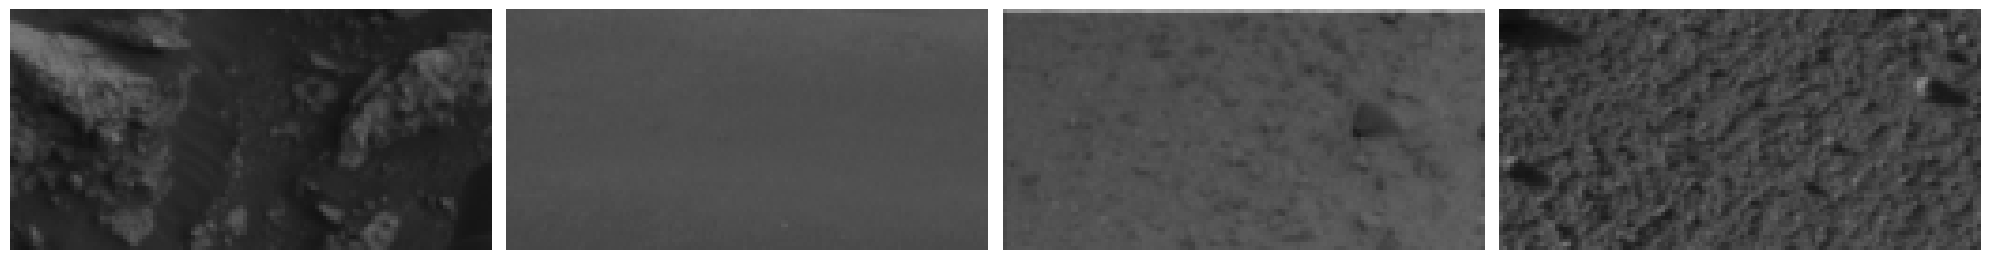

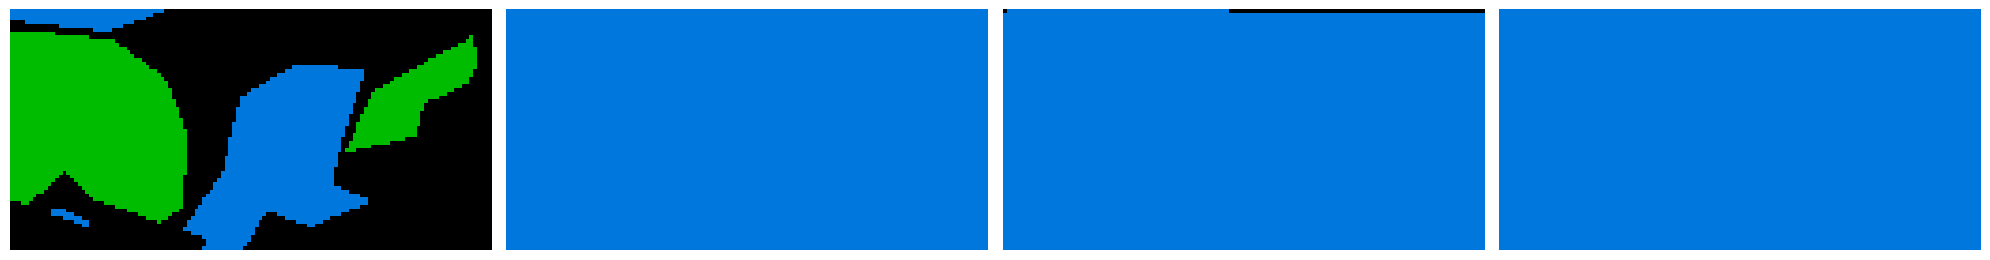

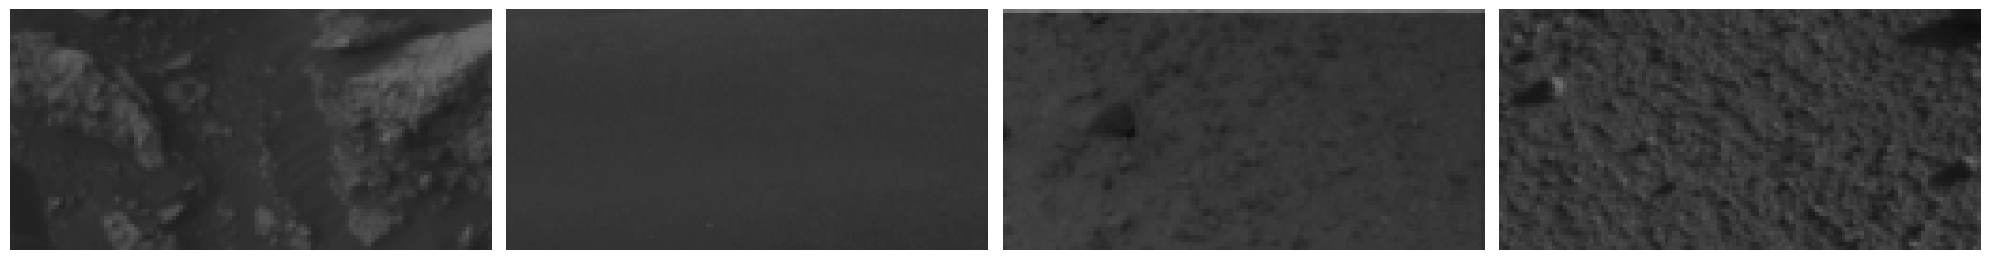

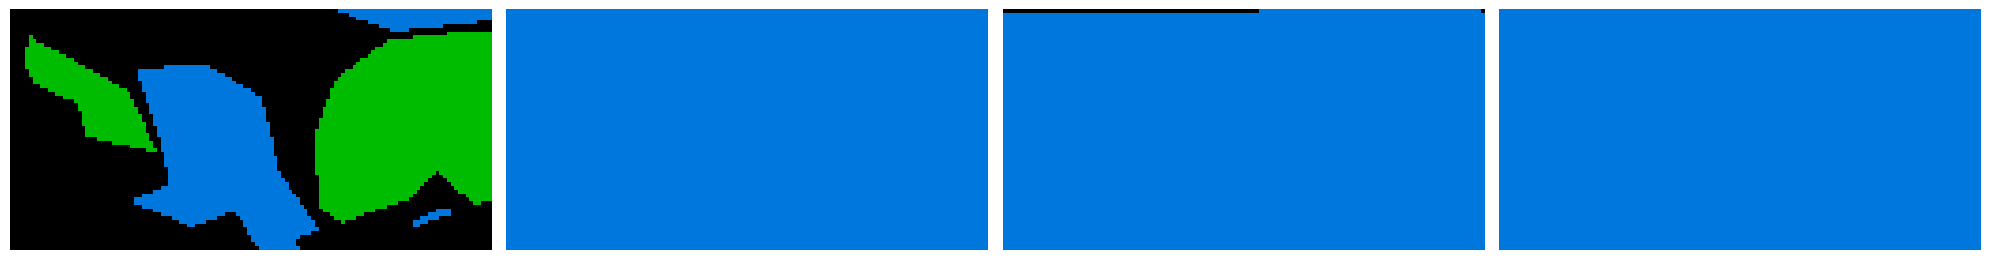

In [ ]:
# Display a sample of augmented images
if print_debugging_info:

  num_img = 4
  random_indices = random.sample(range(len(X_train)), num_img)
  to_plot_X, to_plot_Y = (X_train[random_indices], y_train[random_indices])
  plot_images(to_plot_X, num_img, vmin = 0, vmax = 255, cmap = 'gray')
  plot_images(to_plot_Y, num_img, vmin = 0, vmax = 4, cmap = 'nipy_spectral')

  to_plot_X, to_plot_Y = augmentation(to_plot_X, to_plot_Y)
  plot_images(to_plot_X, num_img, vmin = 0, vmax = 255, cmap = 'gray')
  plot_images(to_plot_Y, num_img, vmin = 0, vmax = 4, cmap = 'nipy_spectral')

## Define custom loss function

In [ ]:
# Define the weights as the inverse of the frequencies
weights = [1/labels[0], 1/labels[1], 1/labels[2], 1/labels[3], 1/labels[4]]

# Optional: set the weight of the background to 0
# weights[0] = 0

# Normalize the weights
weights /= np.sum(weights, keepdims = True)
weights = weights.astype(np.float32)
print(weights)

[0.         0.03183396 0.04517371 0.05188441 0.87110794]


In [ ]:
# Define the new loss function
def new_loss(weights, alpha=0.25, gamma=2.0):
  weights = tf.Variable(weights)

  def boundary_loss(y_true, y_pred):
      # Compute the gradient magnitude of y_true and y_pred
      y_true_grad = tf.image.sobel_edges(y_true)
      y_pred_grad = tf.image.sobel_edges(y_pred)

      # Compute the L2 distance between the gradients
      grad_diff = tfkb.square(y_true_grad - y_pred_grad)

      # Sum up the gradient differences
      loss = tfkb.sum(grad_diff, axis=[1, 2, 3, 4])

      # Reduce mean over the batch
      return tfkb.mean(loss)

  def focal_loss(y_true, y_pred):
      # Clip predictions to prevent log(0)
      epsilon = tfkb.epsilon()
      y_pred = tfkb.clip(y_pred, epsilon, 1.0 - epsilon)

      # Calculate cross entropy
      cross_entropy = -y_true * tfkb.log(y_pred)

      # Calculate weights: alpha * (1 - p)^gamma for each class
      weights = alpha * tfkb.pow(1 - y_pred, gamma)

      # Compute the final focal loss
      loss = weights * cross_entropy

      # Reduce mean over the batch
      return tfkb.mean(tfkb.sum(loss, axis=-1))

  def loss(y_true, y_pred):
      l = tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0)(y_true,y_pred)
      l2 = tf.keras.losses.SparseCategoricalCrossentropy()(y_true,y_pred)
      y_true_one_hot = tf.one_hot(tf.cast(y_true, np.int32), depth=5)
      y_true_one_hot = tf.multiply(y_true_one_hot, weights)

      # Compute a blend of the different losses
      return l + 0.5 * tf.keras.losses.Dice()(y_true_one_hot,y_pred) + 0.2 * l2
  return loss

## Build the model

In [ ]:
# patch_size: how big will the patches considered by the model be
patch_size = 2

# expansion_factor: factor by which the number of feature channels of the model's layers will be multiplied
expansion_factor = 4

In [ ]:
def block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, regularization_stregth = 0.01, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth), name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [ ]:
# Define the building blocks of the model

# 1) Convolutional block
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = tfkl.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation=tfk.activations.swish,
        padding="same",
    )
    return conv_layer(x)

# 2) Padding block
def correct_pad(inputs, kernel_size):
    img_dim = 2 if tfkb.image_data_format() == "channels_first" else 1
    input_size = inputs.shape[img_dim : (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )

# 3) Inverted residual block
def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = tfkl.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = tfkl.BatchNormalization()(m)
    m = tfk.activations.swish(m)

    if strides == 2:
        m = tfkl.ZeroPadding2D(padding=correct_pad(m, 3))(m)

    m = tfkl.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)

    m = tfkl.BatchNormalization()(m)
    m = tfk.activations.swish(m)

    m = tfkl.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = tfkl.BatchNormalization()(m)

    if tfk.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return tfkl.Add()([m, x])
    return m

# 4) Multi-layer perceptron block
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tfkl.Dense(units, activation=tfk.activations.swish)(x)
        x = tfkl.Dropout(dropout_rate)(x)
    return x

# 5) Transformer block
def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tfkl.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = tfkl.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tfkl.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=0.1,
        )
        # Skip connection 2.
        x = tfkl.Add()([x3, x2])

    return x

# 6) MobileVit block
def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = tfkl.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = tfkl.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = tfkl.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [ ]:
def create_mobilevit(num_classes=5, dropout_rate = 0.2, regularization_stregth = 0.01):
    inputs = tfk.Input((64, 128, 1))
    x = tfkl.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)

    # 1st residual connecton starting point
    bigjump4 = tfkl.Conv2DTranspose(32, (3,3),strides=(2, 2), padding='same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(x)

    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # 2nd residual connecton starting point
    bigjump3 = tfkl.Conv2D(64, (3,3), strides=(1,1), padding = 'same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(x)

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )

    # 3rd residual connecton starting point
    bigjump2 = tfkl.Conv2D(72, (3,3), strides=(1,1), padding = 'same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(x)

    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # 4th residual connecton starting point
    bigjump1 = tfkl.Conv2D(84, (3,3), strides=(2,2), padding = 'same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(x)

    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )

    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )

    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )

    x = mobilevit_block(x, num_blocks=3, projection_dim=96)

    # Decoder
    x = tfkl.Conv2DTranspose(96, (3,3),strides=(2, 2),padding='same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(x)

    # Decoder module 1
    up_block_1 = tfkl.Conv2DTranspose(84,(3,3),strides=(2, 2),padding='same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(x)
    up_block_1 = tfkl.Add()([up_block_1, bigjump1])
    up_block_1 = block(up_block_1, 84, stack=2, regularization_stregth = regularization_stregth, name='up_block1_')
    up_block_1 = tfkl.Dropout(dropout_rate)(up_block_1)

    # Decoder module 2
    up_block_2 = tfkl.Conv2DTranspose(72,(3,3),strides=(2, 2),padding='same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(up_block_1)
    up_block_2 = tfkl.Add()([up_block_2, bigjump2])
    up_block_2 = block(up_block_2, 72, stack=2, regularization_stregth = regularization_stregth, name='up_block2_')
    up_block_2 = tfkl.Dropout(dropout_rate)(up_block_2)

    # Decoder module 3
    up_block_3 = tfkl.Conv2DTranspose(64,(3,3),strides=(2, 2),padding='same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(up_block_2)
    up_block_3 = tfkl.Add()([up_block_3, bigjump3])
    up_block_3 = block(up_block_3, 64, stack=2, regularization_stregth = regularization_stregth, name='up_block3_')
    up_block_3 = tfkl.Dropout(dropout_rate)(up_block_3)

    # Last decoder module (provare bigjump5)
    up_block_4 = tfkl.Conv2DTranspose(32,(3,3),strides=(2, 2),padding='same', activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_stregth))(up_block_3)
    up_block_4 = tfkl.Add()([up_block_4, bigjump4])
    up_block_4 = block(up_block_4, 32, stack=2, regularization_stregth = regularization_stregth, name='up_block4_')
    up_block_4 = tfkl.Dropout(dropout_rate)(up_block_4)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax', name='outputs')(up_block_4)
    return tfk.Model(inputs, outputs)

model = create_mobilevit(dropout_rate = 0.3, regularization_stregth = 0.001)

In [ ]:
if print_debugging_info:

  # Print a detailed summary of the model with expanded nested layers and trainable parameters.
  model.summary(expand_nested=True)

  # Generate and display a graphical representation of the model architecture.
  # tf.keras.utils.plot_model(model, show_shapes=False, expand_nested=False, dpi=30)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 64, 128, 1)     │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 64, 16)     │            160 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 64, 64)     │          1,024 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 64, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu (Silu)               │ (None, 32, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ depthwise_conv2d          │ (None, 32, 64, 64)     │            576 │ silu[0][0]             │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 64, 64)     │            256 │ depthwise_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_1 (Silu)             │ (None, 32, 64, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 16)     │          1,024 │ silu_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 64, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 64, 16)     │              0 │ batch_normalization_2… │
│                           │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 64, 64)     │          1,024 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 64, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu_2 (Silu)             │ (None, 32, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 33, 65, 64)     │              0 │ silu_2[0][0]           │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 1,968,613 (7.51 MB)

 Trainable params: 1,963,077 (7.49 MB)

 Non-trainable params: 5,536 (21.62 KB)

## Define training callbacks

In [ ]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, num_classes, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            image, label = self.image_path, self.label_path
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(np.squeeze(image[0]), vmin=0, vmax=255,cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(np.squeeze(label), cmap = 'nipy_spectral',vmin=0, vmax=4)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(np.squeeze(y_pred[0]), cmap = 'nipy_spectral',vmin=0, vmax=4)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Model-save callback
class ModelSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath, interval=10):
        super(ModelSaveCallback, self).__init__()
        if '{epoch}' not in filepath:
            raise ValueError("\nFilepath must contain '{epoch}' to format the epoch number.")
        self.filepath = filepath  # Filepath to save the model
        self.interval = interval  # Save interval in epochs

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:  # Check if the current epoch is a multiple of the interval
            filepath = self.filepath.format(epoch=epoch + 1)  # Format the filepath with the epoch number
            self.model.save(filepath)  # Save the model
            print(f"\nSaving model to {filepath}")

# Restore best-weights callback
class SaveAndRestoreWeights(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_mean_iou', mode='max', tolerance_factor=2, total_epochs=300, min_monitor=0.4, min_delta=0.01):
        super(SaveAndRestoreWeights, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.tolerance_factor = tolerance_factor
        self.best = float('inf') if mode == 'min' else -float('inf')
        self.best_epoch = 0
        self.total_epochs = total_epochs
        self.min_monitor = min_monitor
        self.min_delta = min_delta
        self.ever_saved_weights = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn(f"\nCan save best model only with {self.monitor} available, skipping.", RuntimeWarning)
            return

        # Update best weights based on monitored metric
        if (self.mode == 'min' and current < self.best - self.min_delta and current < self.min_monitor) or (self.mode == 'max' and current > self.best + self.min_delta and current > self.min_monitor):
            self.best = current
            self.best_epoch = epoch + 1
            self.model.save_weights(self.filepath, overwrite=True)
            self.ever_saved_weights = True
            print(f"\nSaving best weights to (best {self.monitor}: {self.best})")

        # Restore best weights after every save_freq epochs
        if self.ever_saved_weights and (((self.mode == 'min' and current > self.best * self.tolerance_factor) or (self.mode == 'max' and current < self.best / self.tolerance_factor)) or (epoch + 1) == self.total_epochs):
            self.model.load_weights(self.filepath)
            print(f"\nRestoring best weights from epoch {self.best_epoch}")

## Compile and train the model
The execution of a cell in this block was keyboard-interrupted, which is why the play button shows up red

In [ ]:
# Set batch size for training
batch_size = 64

# Set learning rate for the optimiser
target_learning_rate = 1e-3

# Set early stopping patience threshold
patience = 100

# Set maximum number of training epochs
epochs = 500

# Set the number of epochs in between model saves
epochs_between_checkpoint = 50
tolerance_factor = 2

# Define the metrics used by the larning rate schedulers
# (these were initially used for warmup + cosine decay)
total_steps = len(X_train) / batch_size * epochs
warmup_steps = int(0.1 * total_steps)

hold_steps = 2 * warmup_steps

if print_debugging_info:
  print("Warmup phase will last", int(warmup_steps / batch_size), "epochs.")
  print("Hold phase will last", int(hold_steps / batch_size), "epochs.")

Warmup phase will last 34 epochs.
Hold phase will last 68 epochs.


In [ ]:
# Instatiate callbacks depending on the set options
if generate_validation_slpit:
  viz_callback = VizCallback(X_val[221], y_val[221], num_classes = num_classes, frequency = 10)
  save_and_restore_weights_monitor = 'val_mean_iou'
else:
  viz_callback = VizCallback(X_train[2], y_train[2], num_classes = num_classes, frequency = 10)
  save_and_restore_weights_monitor = 'mean_iou'

model_save_callback = ModelSaveCallback(
    filepath='model_{epoch}.keras',
    interval=epochs_between_checkpoint
)

# Instatiate the restire weights callback
save_and_restore_weights_callback = SaveAndRestoreWeights(
    filepath='best_weights.weights.h5',
    monitor=save_and_restore_weights_monitor,
    mode='max',
    tolerance_factor = tolerance_factor,
    total_epochs = epochs,
    min_monitor = 0.3,
    min_delta = 0.01
)

# Instatiate the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Instatiate the final iou callback (version with validation data)
final_val_iou_callback = tfkc.LambdaCallback(
    on_epoch_end=lambda epoch, logs: setattr(
        final_val_iou_callback,
        'final_val_meanIoU',
        max(logs.get('val_mean_iou', 0), getattr(final_val_iou_callback, 'final_val_meanIoU', 0))
    )
)

# Instatiate the final iou callback (version without validation data)
final_iou_callback = tfkc.LambdaCallback(
    on_epoch_end=lambda epoch, logs: setattr(
        final_iou_callback,
        'final_meanIoU',
        max(logs.get('mean_iou', 0), getattr(final_iou_callback, 'final_meanIoU', 0))
    )
)

# Instatiate reduce learning rate on plateau callback
reduce_lr_on_plateau_callback = tfkc.ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.5,
    patience=30,
    verbose=1,
    mode="max",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-7,
)

In [ ]:
# Group the callbacks
callbacks = [reduce_lr_on_plateau_callback]

if generate_validation_slpit:
    callbacks.append(early_stopping)
    callbacks.append(final_val_iou_callback)
else:
    callbacks.append(final_iou_callback)

if print_training_info:
    callbacks.append(viz_callback)
if save_model_during_training:
    callbacks.append(model_save_callback)
if restore_weights_during_training:
    callbacks.append(save_and_restore_weights_callback)

In [ ]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name = 'mean_iou')

# Compile the model
model.compile(

    # Either of the following 2 losses can be used
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=0),
    #loss = new_loss(weights),

    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=5e-4),

    metrics = [mean_iou,
               tfk.metrics.IoU(5, [1], ignore_class=0, sparse_y_pred = False, name = 'i1'),
               tfk.metrics.IoU(5, [2], ignore_class=0, sparse_y_pred = False, name = 'i2'),
               tfk.metrics.IoU(5, [3], ignore_class=0, sparse_y_pred = False, name = 'i3'),
               tfk.metrics.IoU(5, [4], ignore_class=0, sparse_y_pred = False, name = 'i4')]
)

In [ ]:
# Augment the training data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size, drop_remainder = False).map(lambda x, y: augmentation(x, y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

Epoch 1/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - i1: 0.3441 - i2: 0.2796 - i3: 0.1559 - i4: 0.0306 - loss: 2.2462 - mean_iou: 0.1620  

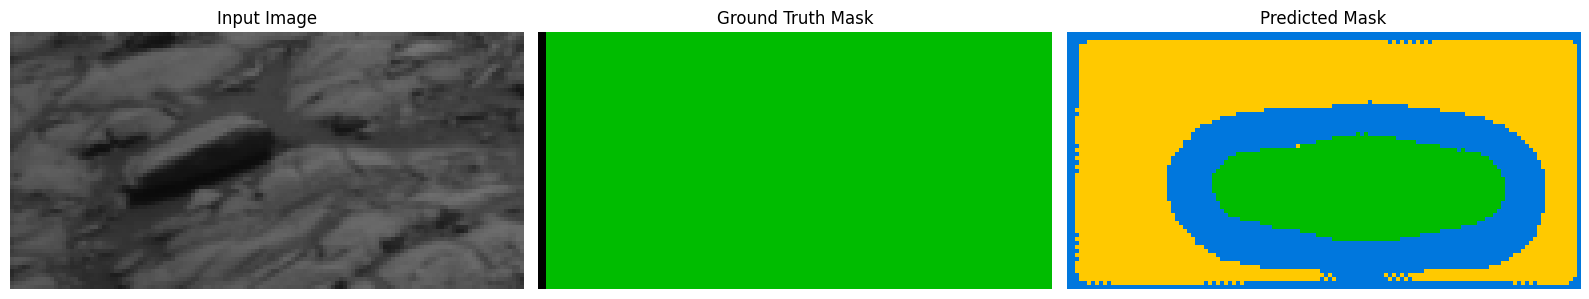

45/45 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - i1: 0.3448 - i2: 0.2815 - i3: 0.1573 - i4: 0.0309 - loss: 2.2392 - mean_iou: 0.1629 - val_i1: 0.2274 - val_i2: 0.1278 - val_i3: 0.1877 - val_i4: 0.0000e+00 - val_loss: 1.9168 - val_mean_iou: 0.1357 - learning_rate: 0.0010
Epoch 2/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.4212 - i2: 0.4558 - i3: 0.3192 - i4: 0.0467 - loss: 1.4187 - mean_iou: 0.2486 - val_i1: 0.0854 - val_i2: 0.0000e+00 - val_i3: 0.2198 - val_i4: 0.0000e+00 - val_loss: 1.6465 - val_mean_iou: 0.0763 - learning_rate: 0.0010
Epoch 3/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - i1: 0.4683 - i2: 0.5059 - i3: 0.4255 - i4: 0.0369 - loss: 1.1804 - mean_iou: 0.2873 - val_i1: 0.0470 - val_i2: 0.0000e+00 - val_i3: 0.2215 - val_i4: 0.0000e+00 - val_loss: 1.7416 - val_mean_iou: 0.0671 - learning_rate: 0.0010
Epoch 4/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.5212 - i2: 0.5340 - i3: 0.5193 - i4: 0.0303 - loss: 1.0333 - mean_iou: 0.3210 - val_i1: 0.0045 - val_i2: 0.0000e+00 

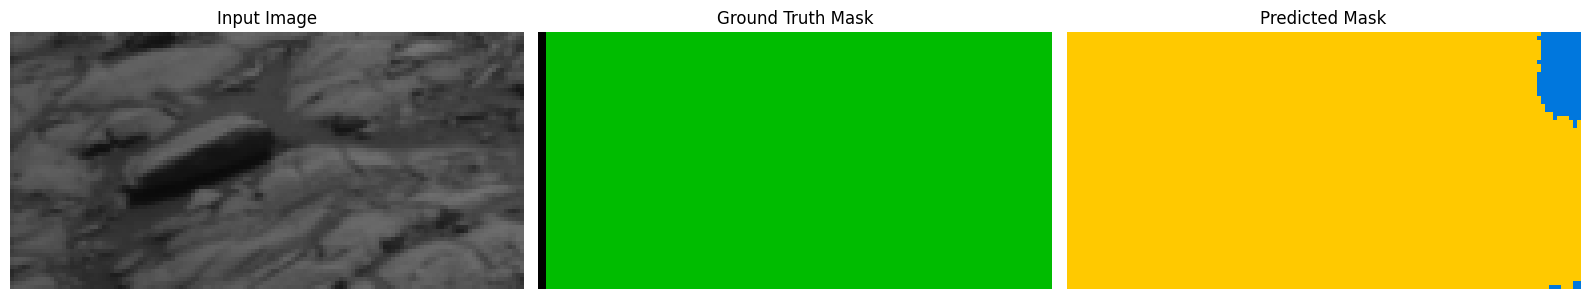

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - i1: 0.6710 - i2: 0.5959 - i3: 0.6508 - i4: 0.0274 - loss: 0.7197 - mean_iou: 0.3890 - val_i1: 0.2968 - val_i2: 0.0042 - val_i3: 0.2739 - val_i4: 0.0000e+00 - val_loss: 1.5665 - val_mean_iou: 0.1437 - learning_rate: 0.0010
Epoch 12/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - i1: 0.6897 - i2: 0.6000 - i3: 0.6691 - i4: 0.0365 - loss: 0.6908 - mean_iou: 0.4056 - val_i1: 0.5650 - val_i2: 0.3049 - val_i3: 0.4557 - val_i4: 0.0000e+00 - val_loss: 0.9643 - val_mean_iou: 0.3314 - learning_rate: 0.0010
Epoch 13/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - i1: 0.6894 - i2: 0.6034 - i3: 0.6601 - i4: 0.0262 - loss: 0.6913 - mean_iou: 0.3999 - val_i1: 0.6229 - val_i2: 0.5434 - val_i3: 0.5785 - val_i4: 0.0000e+00 - val_loss: 0.7183 - val_mean_iou: 0.4362 - learning_rate: 0.0010
Epoch 14/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - i1: 0.6979 - i2: 0.6136 - i3: 0.6757 - i4: 0.0345 - loss: 0.6592 - mean_iou: 0.4066 - val_i1: 0.5827 - val_i2: 0.5420 - val_i3:

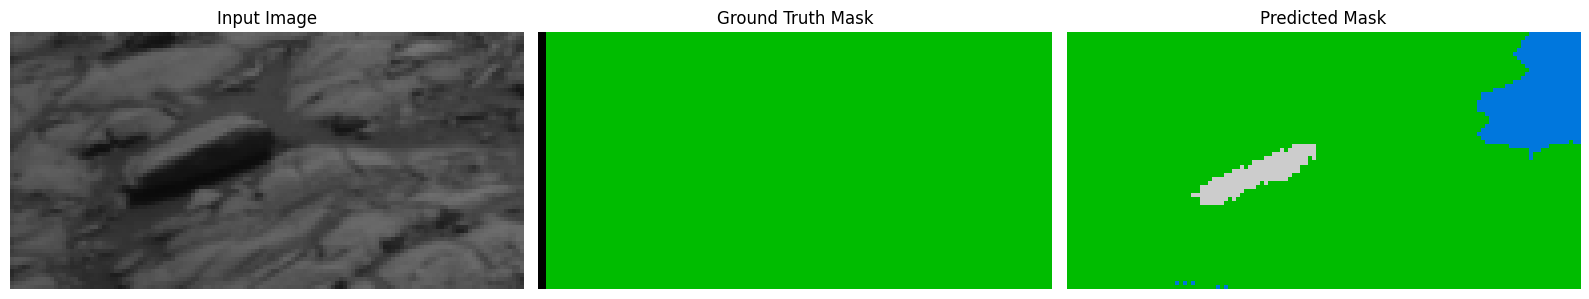

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - i1: 0.7118 - i2: 0.6178 - i3: 0.6914 - i4: 0.0174 - loss: 0.6222 - mean_iou: 0.4077 - val_i1: 0.4774 - val_i2: 0.3984 - val_i3: 0.3330 - val_i4: 1.5372e-04 - val_loss: 1.2435 - val_mean_iou: 0.3022 - learning_rate: 0.0010
Epoch 22/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7069 - i2: 0.6170 - i3: 0.6940 - i4: 0.0328 - loss: 0.6161 - mean_iou: 0.4123 - val_i1: 0.5090 - val_i2: 0.3821 - val_i3: 0.3192 - val_i4: 0.0000e+00 - val_loss: 1.1398 - val_mean_iou: 0.3026 - learning_rate: 0.0010
Epoch 23/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - i1: 0.7104 - i2: 0.6247 - i3: 0.6801 - i4: 0.0095 - loss: 0.6119 - mean_iou: 0.4049 - val_i1: 0.4059 - val_i2: 0.4077 - val_i3: 0.3622 - val_i4: 0.0000e+00 - val_loss: 1.5429 - val_mean_iou: 0.2939 - learning_rate: 0.0010
Epoch 24/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - i1: 0.7050 - i2: 0.6183 - i3: 0.6779 - i4: 0.0088 - loss: 0.6146 - mean_iou: 0.4020 - val_i1: 0.4762 - val_i2: 0.4643 - val_i3:

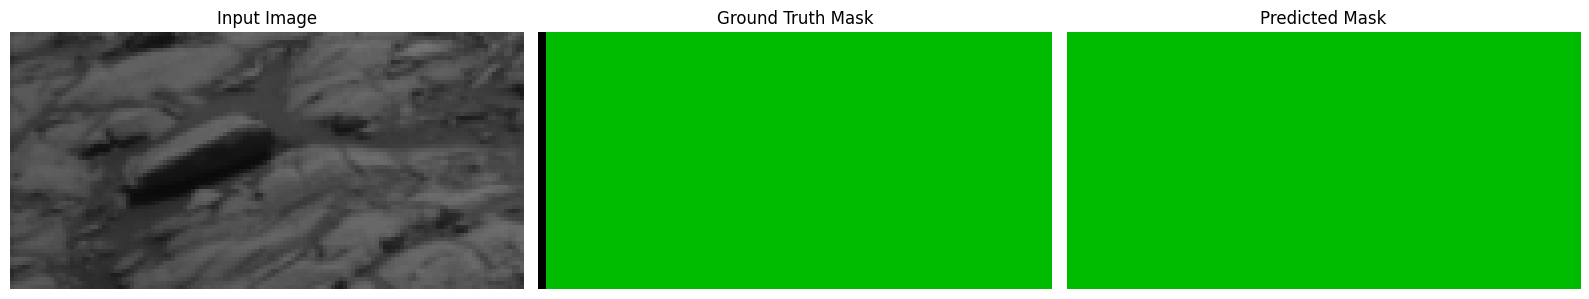

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - i1: 0.7280 - i2: 0.6421 - i3: 0.7022 - i4: 0.0080 - loss: 0.5758 - mean_iou: 0.4229 - val_i1: 0.3314 - val_i2: 0.3931 - val_i3: 0.4702 - val_i4: 3.8961e-05 - val_loss: 1.6135 - val_mean_iou: 0.2987 - learning_rate: 0.0010
Epoch 32/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7297 - i2: 0.6459 - i3: 0.6987 - i4: 0.0215 - loss: 0.5641 - mean_iou: 0.4307 - val_i1: 0.3245 - val_i2: 0.4122 - val_i3: 0.2808 - val_i4: 0.0019 - val_loss: 1.4793 - val_mean_iou: 0.2549 - learning_rate: 0.0010
Epoch 33/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - i1: 0.7275 - i2: 0.6458 - i3: 0.6926 - i4: 0.0436 - loss: 0.5743 - mean_iou: 0.4335 - val_i1: 0.3757 - val_i2: 0.3956 - val_i3: 0.3829 - val_i4: 5.8596e-04 - val_loss: 1.4405 - val_mean_iou: 0.2887 - learning_rate: 0.0010
Epoch 34/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - i1: 0.7338 - i2: 0.6389 - i3: 0.7104 - i4: 0.0254 - loss: 0.5641 - mean_iou: 0.4217 - val_i1: 0.5089 - val_i2: 0.4461 - val_i3: 0.5

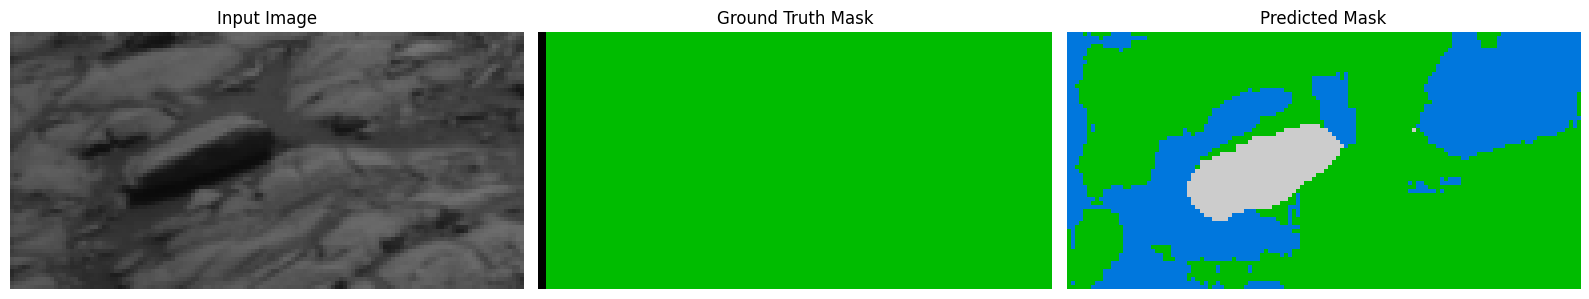

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - i1: 0.7401 - i2: 0.6582 - i3: 0.7136 - i4: 0.1027 - loss: 0.5393 - mean_iou: 0.5537 - val_i1: 0.5147 - val_i2: 0.3859 - val_i3: 0.5205 - val_i4: 0.0066 - val_loss: 1.2097 - val_mean_iou: 0.3569 - learning_rate: 0.0010
Epoch 42/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7418 - i2: 0.6690 - i3: 0.7166 - i4: 0.1500 - loss: 0.5333 - mean_iou: 0.5694 - val_i1: 0.5389 - val_i2: 0.4302 - val_i3: 0.4758 - val_i4: 2.5820e-04 - val_loss: 1.1143 - val_mean_iou: 0.3613 - learning_rate: 0.0010
Epoch 43/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7573 - i2: 0.6782 - i3: 0.7303 - i4: 0.1682 - loss: 0.5071 - mean_iou: 0.5835 - val_i1: 0.5009 - val_i2: 0.4175 - val_i3: 0.4302 - val_i4: 0.0017 - val_loss: 1.3799 - val_mean_iou: 0.3376 - learning_rate: 0.0010
Epoch 44/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - i1: 0.7379 - i2: 0.6544 - i3: 0.7166 - i4: 0.1376 - loss: 0.5488 - mean_iou: 0.5616
Epoch 44: ReduceLROnPlateau reducing learning rate 

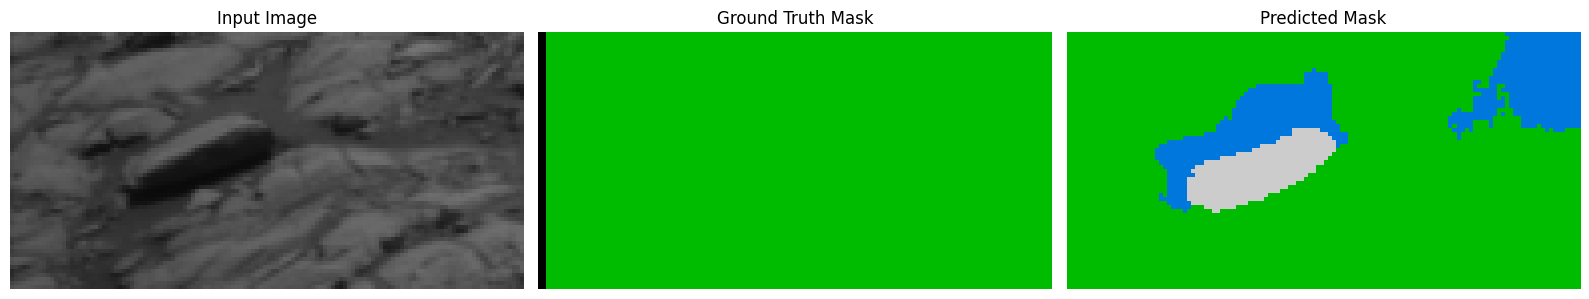

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - i1: 0.7826 - i2: 0.7027 - i3: 0.7404 - i4: 0.2078 - loss: 0.4636 - mean_iou: 0.6084 - val_i1: 0.4989 - val_i2: 0.3913 - val_i3: 0.5331 - val_i4: 0.0064 - val_loss: 1.0526 - val_mean_iou: 0.3574 - learning_rate: 5.0000e-04
Epoch 52/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7716 - i2: 0.6901 - i3: 0.7372 - i4: 0.2434 - loss: 0.4750 - mean_iou: 0.6106 - val_i1: 0.5050 - val_i2: 0.3998 - val_i3: 0.4720 - val_i4: 0.0045 - val_loss: 1.0493 - val_mean_iou: 0.3453 - learning_rate: 5.0000e-04
Epoch 53/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7810 - i2: 0.7015 - i3: 0.7501 - i4: 0.2344 - loss: 0.4572 - mean_iou: 0.6167 - val_i1: 0.5139 - val_i2: 0.4144 - val_i3: 0.4283 - val_i4: 0.0029 - val_loss: 1.1127 - val_mean_iou: 0.3399 - learning_rate: 5.0000e-04
Epoch 54/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - i1: 0.7814 - i2: 0.7044 - i3: 0.7539 - i4: 0.2670 - loss: 0.4548 - mean_iou: 0.6267 - val_i1: 0.5653 - val_i2: 0.4295 - val_i3:

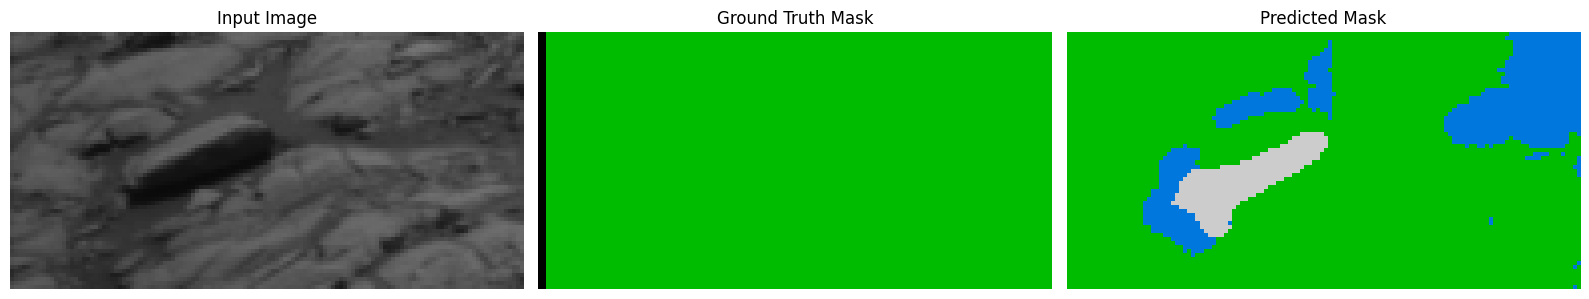

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - i1: 0.7832 - i2: 0.7134 - i3: 0.7564 - i4: 0.2906 - loss: 0.4424 - mean_iou: 0.6359 - val_i1: 0.5078 - val_i2: 0.3589 - val_i3: 0.3135 - val_i4: 5.9144e-04 - val_loss: 1.4262 - val_mean_iou: 0.2952 - learning_rate: 5.0000e-04
Epoch 62/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7756 - i2: 0.7014 - i3: 0.7521 - i4: 0.3105 - loss: 0.4476 - mean_iou: 0.6349 - val_i1: 0.4978 - val_i2: 0.3088 - val_i3: 0.3749 - val_i4: 0.0017 - val_loss: 1.2264 - val_mean_iou: 0.2958 - learning_rate: 5.0000e-04
Epoch 63/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7723 - i2: 0.7097 - i3: 0.7465 - i4: 0.3183 - loss: 0.4617 - mean_iou: 0.6367 - val_i1: 0.4847 - val_i2: 0.3805 - val_i3: 0.3938 - val_i4: 0.0014 - val_loss: 1.1396 - val_mean_iou: 0.3151 - learning_rate: 5.0000e-04
Epoch 64/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7890 - i2: 0.7185 - i3: 0.7549 - i4: 0.3389 - loss: 0.4361 - mean_iou: 0.6503 - val_i1: 0.4876 - val_i2: 0.2377 - val

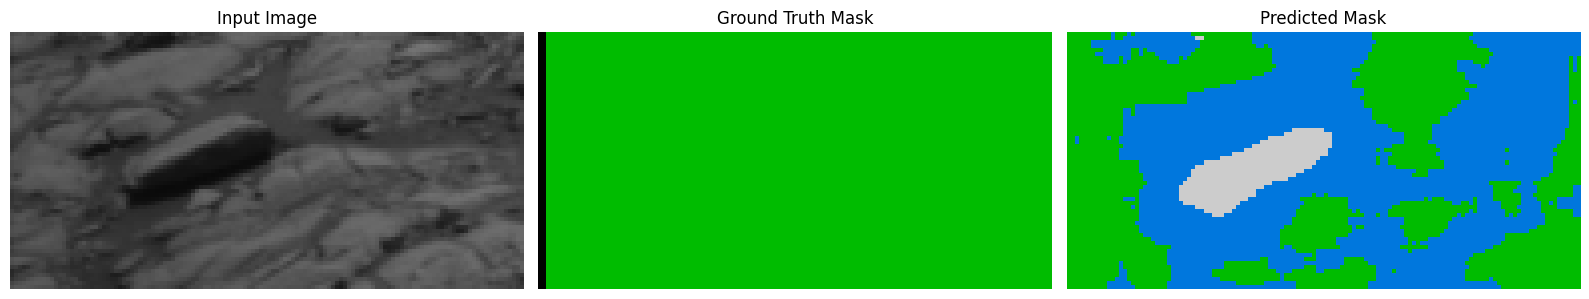

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - i1: 0.7926 - i2: 0.7218 - i3: 0.7706 - i4: 0.3632 - loss: 0.4202 - mean_iou: 0.6620 - val_i1: 0.4654 - val_i2: 0.3472 - val_i3: 0.4679 - val_i4: 0.0016 - val_loss: 1.0795 - val_mean_iou: 0.3205 - learning_rate: 5.0000e-04
Epoch 72/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - i1: 0.7929 - i2: 0.7240 - i3: 0.7664 - i4: 0.3476 - loss: 0.4230 - mean_iou: 0.6577 - val_i1: 0.5160 - val_i2: 0.2921 - val_i3: 0.3036 - val_i4: 0.0035 - val_loss: 1.2461 - val_mean_iou: 0.2788 - learning_rate: 5.0000e-04
Epoch 73/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.7934 - i2: 0.7206 - i3: 0.7814 - i4: 0.3498 - loss: 0.4206 - mean_iou: 0.6613 - val_i1: 0.5769 - val_i2: 0.4011 - val_i3: 0.4921 - val_i4: 0.0054 - val_loss: 1.0000 - val_mean_iou: 0.3689 - learning_rate: 5.0000e-04
Epoch 74/500
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - i1: 0.7983 - i2: 0.7268 - i3: 0.7754 - i4: 0.3525 - loss: 0.4160 - mean_iou: 0.6633
Epoch 74: ReduceLROnPlateau reducing learni

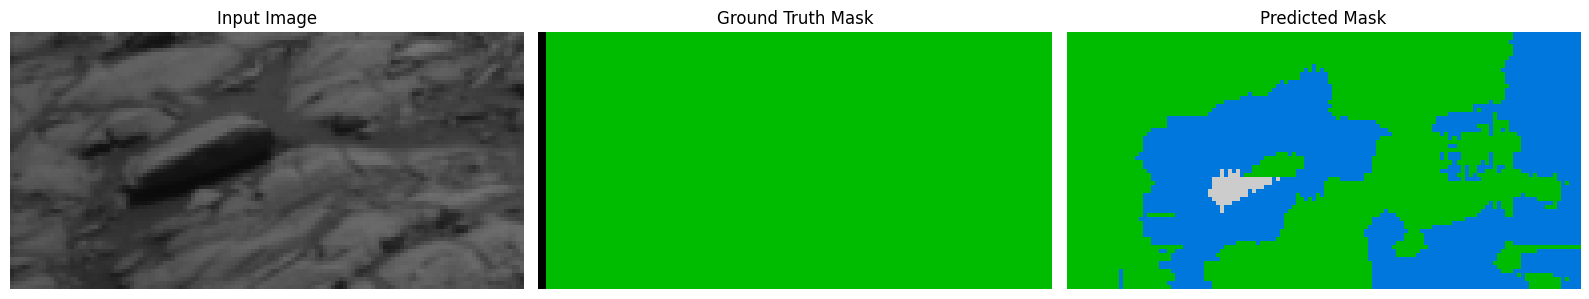

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - i1: 0.8120 - i2: 0.7454 - i3: 0.7876 - i4: 0.4412 - loss: 0.3884 - mean_iou: 0.6965 - val_i1: 0.5044 - val_i2: 0.3667 - val_i3: 0.3672 - val_i4: 1.7365e-04 - val_loss: 1.0696 - val_mean_iou: 0.3096 - learning_rate: 2.5000e-04
Epoch 82/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - i1: 0.8146 - i2: 0.7537 - i3: 0.7919 - i4: 0.4581 - loss: 0.3734 - mean_iou: 0.7046 - val_i1: 0.4940 - val_i2: 0.3918 - val_i3: 0.4261 - val_i4: 1.7456e-04 - val_loss: 1.0557 - val_mean_iou: 0.3280 - learning_rate: 2.5000e-04
Epoch 83/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.8162 - i2: 0.7529 - i3: 0.7880 - i4: 0.4190 - loss: 0.3881 - mean_iou: 0.6940 - val_i1: 0.5202 - val_i2: 0.3990 - val_i3: 0.3988 - val_i4: 1.9031e-04 - val_loss: 1.0316 - val_mean_iou: 0.3296 - learning_rate: 2.5000e-04
Epoch 84/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - i1: 0.8086 - i2: 0.7518 - i3: 0.7878 - i4: 0.4633 - loss: 0.3880 - mean_iou: 0.7029 - val_i1: 0.5206 - val_i2: 0.39

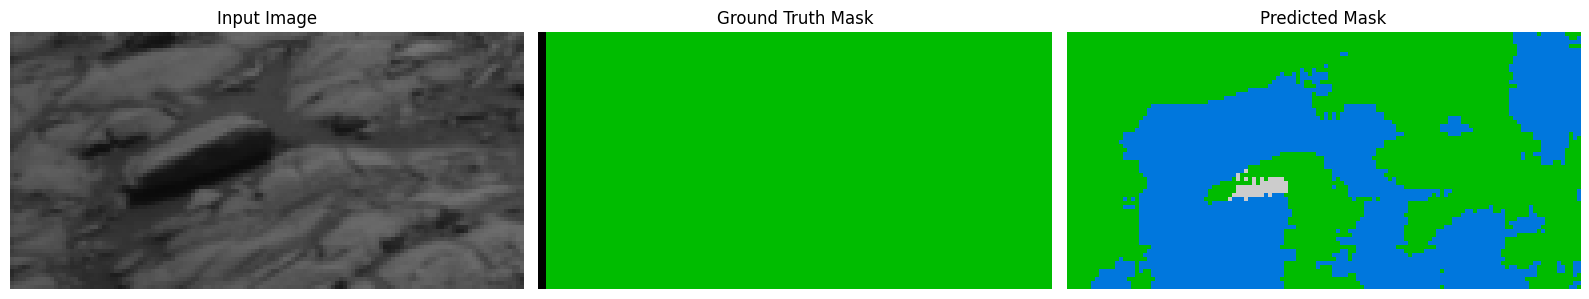

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - i1: 0.8181 - i2: 0.7520 - i3: 0.7920 - i4: 0.5242 - loss: 0.3786 - mean_iou: 0.7216 - val_i1: 0.5206 - val_i2: 0.4207 - val_i3: 0.4073 - val_i4: 3.1754e-04 - val_loss: 1.0486 - val_mean_iou: 0.3372 - learning_rate: 2.5000e-04
Epoch 92/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - i1: 0.8202 - i2: 0.7586 - i3: 0.8014 - i4: 0.4751 - loss: 0.3689 - mean_iou: 0.7138 - val_i1: 0.5136 - val_i2: 0.3938 - val_i3: 0.4178 - val_i4: 3.2304e-04 - val_loss: 1.1114 - val_mean_iou: 0.3314 - learning_rate: 2.5000e-04
Epoch 93/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - i1: 0.8231 - i2: 0.7622 - i3: 0.8057 - i4: 0.5130 - loss: 0.3579 - mean_iou: 0.7260 - val_i1: 0.5050 - val_i2: 0.3864 - val_i3: 0.4332 - val_i4: 2.0884e-04 - val_loss: 1.1333 - val_mean_iou: 0.3312 - learning_rate: 2.5000e-04
Epoch 94/500
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - i1: 0.8161 - i2: 0.7565 - i3: 0.8028 - i4: 0.5019 - loss: 0.3694 - mean_iou: 0.7193 - val_i1: 0.5352 - val_i2: 0.46

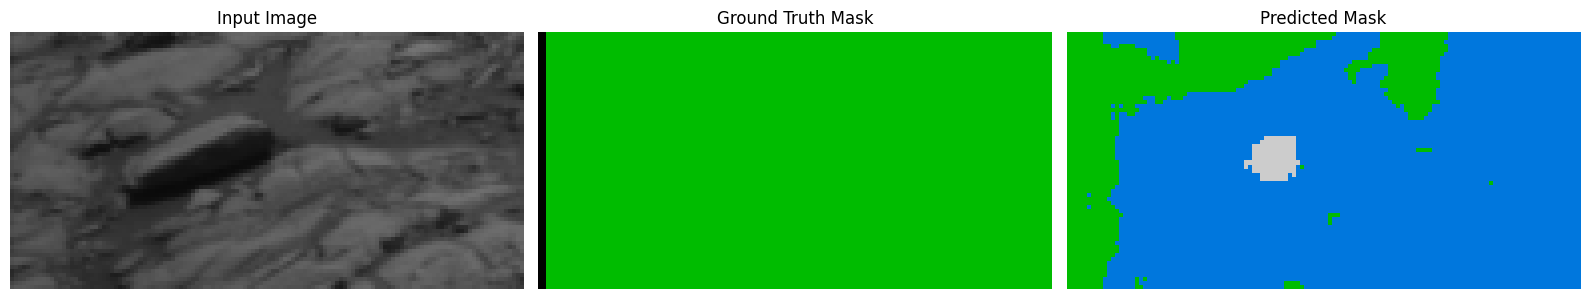

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - i1: 0.8045 - i2: 0.7392 - i3: 0.7783 - i4: 0.4943 - loss: 0.3995 - mean_iou: 0.7041 - val_i1: 0.5528 - val_i2: 0.3695 - val_i3: 0.3161 - val_i4: 5.1220e-04 - val_loss: 1.1394 - val_mean_iou: 0.3097 - learning_rate: 2.5000e-04
Epoch 102/500
37/45 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - i1: 0.8234 - i2: 0.7658 - i3: 0.8042 - i4: 0.5314 - loss: 0.3580 - mean_iou: 0.7312

KeyboardInterrupt: 

In [ ]:
# Please note that the execution of this cell was keyboard-interrupted as it was not yelding satisfactory results

# Train the model
if generate_validation_slpit:
  model.fit(
      train_dataset,
      validation_data = [X_val, y_val],
      epochs=epochs,
      callbacks=callbacks,
      verbose=1
  )
else:
  model.fit(
      train_dataset,
      epochs=epochs,
      callbacks=callbacks,
      verbose=1
  )

if generate_validation_slpit:
  # Calculate and print the final validation mean IoU
  final_val_meanIoU = round(final_val_iou_callback.final_val_meanIoU * 100, 2)
  print(f"Final validation mean IoU: {final_val_meanIoU}%")
  model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
else:
  # Calculate and print the final mean IoU
  final_meanIoU = round(final_iou_callback.final_meanIoU * 100, 2)
  print(f"Final mean IoU: {final_meanIoU}%")
  model_filename = 'UNet_'+str(final_meanIoU)+'.keras'

# Save and then delete the model to free up resources
model.save(model_filename)
print(f"Model saved to {model_filename}")

In [ ]:
# Delete the model to free up resources
del model
gc.collect()

## Prepare the submission

In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
# Load the trained model
model = tfk.models.load_model(model_filename, custom_objects={'loss': new_loss})
print(f"Model loaded from {model_filename}")

Model loaded from UNet_65.9.keras


In [ ]:
# Compute predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step
Predictions shape: (2, 10022, 64, 128)


In [ ]:
# Convert predictions to the format suitable to the Kaggle leaderboard
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)